<a href="https://colab.research.google.com/github/farhan1503001/Time-Series-Analysis-and-Natural-Language-Processing/blob/main/Time_Series_Data_Prediction_Using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tf-nightly-2.0-preview


     |████████████████████████████████| 95.2MB 31kB/s 
     |████████████████████████████████| 450kB 37.3MB/s 
     |████████████████████████████████| 3.8MB 12.8MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.1 which is incompatible.
ERROR: tb-nightly 2.1.0a20191206 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


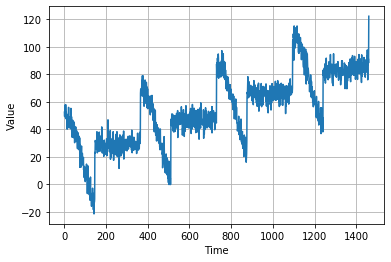

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)
plot_series(time,series,format='-')

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(size=window_size+1,shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda window:window.batch(window_size+1))
  dataset=dataset.map(lambda window:(window[:-1],window[-1:]))
  dataset=dataset.shuffle(shuffle_buffer)
  dataset=dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
980/980 [==============================] - 7s 7ms/step - loss: 28.9301 - mae: 29.4271
Epoch 2/100
980/980 [==============================] - 2s 3ms/step - loss: 19.6310 - mae: 20.1242
Epoch 3/100
980/980 [==============================] - 2s 3ms/step - loss: 18.9226 - mae: 19.4165
Epoch 4/100
980/980 [==============================] - 2s 3ms/step - loss: 17.6370 - mae: 18.1296
Epoch 5/100
980/980 [==============================] - 2s 3ms/step - loss: 16.1249 - mae: 16.6173
Epoch 6/100
980/980 [==============================] - 2s 3ms/step - loss: 15.3985 - mae: 15.8906
Epoch 7/100
980/980 [==============================] - 2s 3ms/step - loss: 14.9308 - mae: 15.4235
Epoch 8/100
980/980 [==============================] - 2s 3ms/step - loss: 14.5220 - mae: 15.0143
Epoch 9/100
980/980 [==============================] - 2s 3ms/step - loss: 14.1439 - mae: 14.6354
Epoch 10/100
980/980 [==============================] - 2s 3ms/step - loss: 13.8269 - mae: 14.3184
Epoch 11/100
980/98

[1e-08, 0.0001, 0, 30]

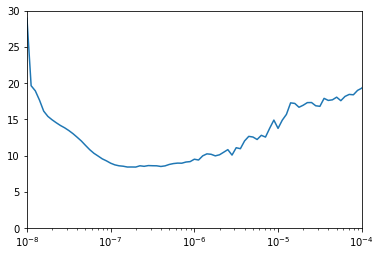

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,-1),input_shape=[None]),
  tf.keras.layers.SimpleRNN(40,return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 2s 188ms/step - loss: 114.0664 - mae: 117.3380
Epoch 2/400
8/8 [==============================] - 0s 32ms/step - loss: 43.6153 - mae: 44.7210
Epoch 3/400
8/8 [==============================] - 0s 33ms/step - loss: 22.3106 - mae: 22.8476
Epoch 4/400
8/8 [==============================] - 0s 33ms/step - loss: 13.3127 - mae: 13.8089
Epoch 5/400
8/8 [==============================] - 0s 33ms/step - loss: 10.7699 - mae: 11.3247
Epoch 6/400
8/8 [==============================] - 0s 33ms/step - loss: 9.1450 - mae: 9.7031
Epoch 7/400
8/8 [==============================] - 0s 30ms/step - loss: 7.5649 - mae: 8.0134
Epoch 8/400
8/8 [==============================] - 0s 31ms/step - loss: 6.8308 - mae: 7.2831
Epoch 9/400
8/8 [==============================] - 0s 31ms/step - loss: 6.3624 - mae: 6.7882
Epoch 10/400
8/8 [==============================] - 0s 34ms/step - loss: 5.8672 - mae: 6.3985
Epoch 11/400
8/8 [==============================] - 0s 3

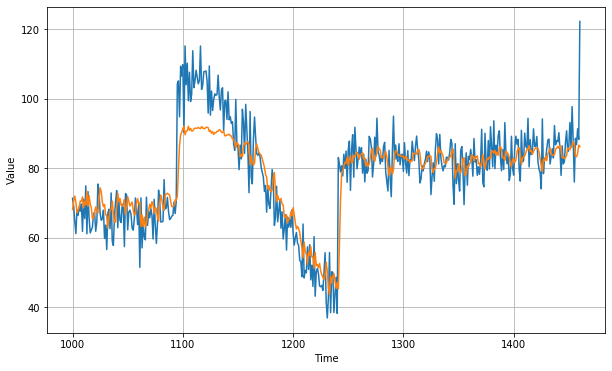

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

<Figure size 432x288 with 0 Axes>

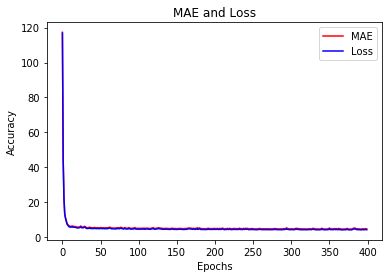

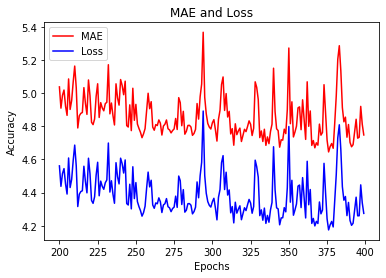

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()